In [ ]:
# !pip install datasets py7zr pandas
# .\sporttech-env\Scripts\Activate

## Setup and Library Imports

In [1]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## Load Dataset from HuggingFace

In [4]:
def load_sportvu_dataset():
    """
    Load the SportVU dataset from HuggingFace
    Dataset: dcayton/nba_tracking_data_15_16
    
    Returns:
    - dataset: loaded dataset object
    """
    print("Loading SportVU dataset from HuggingFace...")
    print("Dataset: dcayton/nba_tracking_data_15_16")
    
    try:
        # Load the dataset
        dataset = load_dataset("dcayton/nba_tracking_data_15_16", "tiny", split="train")
        print(f"Dataset loaded successfully: {len(dataset)} records available")
        
        # Display structure of first record
        print("\nFirst record keys:")
        print(dataset[0].keys())
        
        return dataset
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

# Load the dataset
dataset = load_sportvu_dataset()


Loading SportVU dataset from HuggingFace...
Dataset: dcayton/nba_tracking_data_15_16
Dataset loaded successfully: 2219 records available

First record keys:
dict_keys(['gameid', 'gamedate', 'event_info', 'primary_info', 'secondary_info', 'visitor', 'home', 'moments'])


## Exploration

In [ ]:
from collections import Counter, defaultdict
import math, statistics as stats
import pprint, itertools
pp = pprint.PrettyPrinter(indent=2, width=120)

def safe_len(x):
    try: return len(x)
    except: return math.nan

def sample_non_null(col):
    for v in col:
        if v is not None:
            return v
    return None

def list_len_stats(col):
    lengths = [safe_len(v) for v in col if isinstance(v, (list, tuple))]
    lengths = [l for l in lengths if isinstance(l, (int, float)) and not math.isnan(l)]
    if not lengths:
        return {}
    return {
        "count_lists": len(lengths),
        "min": min(lengths),
        "p25": sorted(lengths)[int(0.25*(len(lengths)-1))],
        "median": stats.median(lengths),
        "p75": sorted(lengths)[int(0.75*(len(lengths)-1))],
        "max": max(lengths),
        "mean": round(sum(lengths)/len(lengths),2),
    }

def dict_keys_union(col, max_rows=500):
    keys = set()
    c = 0
    for v in col:
        if isinstance(v, dict):
            keys |= set(v.keys())
        elif isinstance(v, list):
            for it in v:
                if isinstance(it, dict):
                    keys |= set(it.keys())
        c += 1
        if c>=max_rows: break
    return sorted(keys)

def type_overview(ds, max_rows=1000):
    print(f"Records: {len(ds)}")
    print("\n== Features (schema HuggingFace) ==")
    print(ds.features)

    colnames = list(ds.features.keys())
    print("\n== Colonne ==")
    print(colnames)

    print("\n== Tipi Python osservati su un campione ==")
    for name in colnames:
        vals = (ds[name][:max_rows] if hasattr(ds[name], "__getitem__") else [ds[name]])
        types = Counter(type(v).__name__ for v in vals)
        print(f"- {name}: {dict(types)}")

    print("\n== Esempio primo record: chiavi e tipi ==")
    first = ds[0]
    for k,v in first.items():
        print(f"  {k:20s} -> {type(v).__name__} | preview:", (str(v)[:120] + "...") if isinstance(v, (str,list,dict)) else v)

    # Analisi specifica per colonne list/dict comuni
    for name in colnames:
        col = ds[name][:max_rows]
        if any(isinstance(v, (list, tuple)) for v in col):
            stats_len = list_len_stats(col)
            if stats_len:
                print(f"\n-- {name}: statistiche lunghezze liste --")
                pp.pprint(stats_len)

            # Se è lista di dict, mostra unione chiavi e un campione
            sample = sample_non_null(col)
            list_of_dicts = isinstance(sample, list) and sample and isinstance(sample[0], dict)
            if list_of_dicts:
                keys = dict_keys_union(col)
                print(f"   {name}: unione chiavi degli elementi-dict:")
                print("   ", keys[:60], ("... (+ altri)" if len(keys)>60 else ""))

                # stampa 1 elemento rappresentativo
                print(f"   {name}: esempio primo elemento:")
                pp.pprint(sample[0])

        elif any(isinstance(v, dict) for v in col):
            keys = dict_keys_union(col)
            print(f"\n-- {name}: chiavi presenti nei dict --")
            print("   ", keys)

    # Heuristics: cosa rappresenta una riga?
    hints = []
    for cand in ["game_id","gameId","gameid","match_id","event_id","id"]:
        if cand in colnames:
            uniq = len(set(ds[cand][:min(len(ds), max_rows)]))
            hints.append((cand, uniq))
    if hints:
        print("\n== Indizi su cosa rappresenta una riga ==")
        for k,u in hints:
            print(f"- Colonna {k}: {u} valori unici su {min(len(ds), max_rows)} record")

    print("\n== Campioni strutture annidate (moments/events se presenti) ==")
    for key in ["moments","moment","events","play_by_play","pbp"]:
        if key in ds.features:
            val = sample_non_null(ds[key])
            print(f"\n[key={key}] tipo={type(val).__name__}, lunghezza={safe_len(val)}")
            if isinstance(val, list) and val:
                print("  Primo elemento tipo:", type(val[0]).__name__)
                if isinstance(val[0], list):
                    print("  Primo elemento-list preview:", str(val[0])[:200], "...")
                if isinstance(val[0], dict):
                    print("  Chiavi del primo elemento-dict:", list(val[0].keys()))
            elif isinstance(val, dict):
                print("  Chiavi del dict:", list(val.keys()))
            else:
                print("  Preview:", str(val)[:200])

# Esegui analisi
type_overview(dataset)


Records: 2219

== Features (schema HuggingFace) ==
{'gameid': Value('string'),

 'gamedate': Value('string'),

 'event_info': {'id': Value('string'), 'type': Value('int64'), 'possession_team_id': Value('float64'), 'desc_home': Value('string'), 'desc_away': Value('string')}, 

 'primary_info': {'team': Value('string'), 'player_id': Value('float64'), 'team_id': Value('float64')}, 

 'secondary_info': {'team': Value('string'), 'player_id': Value('float64'), 'team_id': Value('float64')}, 

 'visitor': {'name': Value('string'), 'teamid': Value('int64'), 'abbreviation': Value('string'), 'players': List({'lastname': Value('string'), 'firstname': Value('string'), 'playerid': Value('int64'), 'jersey': Value('string'), 'position': Value('string')})}, 

 'home': {'name': Value('string'), 'teamid': Value('int64'), 'abbreviation': Value('string'), 'players': List({'lastname': Value('string'), 'firstname': Value('string'), 'playerid': Value('int64'), 'jersey': Value('string'), 'position': Value('string')})}, 
 
 'moments': List({'quarter': Value('int64'), 'game_clock': Value('float64'), 'shot_clock': Value('float64'), 'ball_coordinates': {'x': Value('float64'), 'y': Value('float64'), 'z': Value('float64')}, 'player_coordinates': List({'teamid': Value('int32'), 'playerid': Value('int32'), 'x': Value('float64'), 'y': Value('float64'), 'z': Value('float64')})})}

== Colonne ==
['gameid', 'gamedate', 'event_info', 'primary_info', 'secondary_info', 'visitor', 'home', 'moments']

== Tipi Python osservati su un campione ==
- gameid: {'str': 1000}
- gamedate: {'str': 1000}
- event_info: {'dict': 1000}
- primary_info: {'dict': 1000}
- secondary_info: {'dict': 1000}
- visitor: {'dict': 1000}
- home: {'dict': 1000}
- moments: {'list': 1000}

== Esempio primo record: chiavi e tipi ==
  gameid               -> str | preview: 0021500333...
  gamedate             -> str | preview: 2015-12-11...
  event_info           -> dict | preview: {'id': '1', 'type': 10, 'possession_team_id': None, 'desc_home': 'Jump Ball Mahinmi vs. Whiteside: Tip to Allen', 'desc_...
  primary_info         -> dict | preview: {'team': 'home', 'player_id': 101133.0, 'team_id': 1610612754.0}...
  secondary_info       -> dict | preview: {'team': 'away', 'player_id': 202355.0, 'team_id': 1610612748.0}...
  visitor              -> dict | preview: {'name': 'Miami Heat', 'teamid': 1610612748, 'abbreviation': 'MIA', 'players': [{'lastname': 'Andersen', 'firstname': 'C...
  home                 -> dict | preview: {'name': 'Indiana Pacers', 'teamid': 1610612754, 'abbreviation': 'IND', 'players': [{'lastname': 'Mahinmi', 'firstname':...
  moments              -> list | preview: [{'quarter': 1, 'game_clock': 707.65, 'shot_clock': 24.0, 'ball_coordinates': {'x': 5.48747, 'y': 24.25562, 'z': 4.88724...

-- event_info: chiavi presenti nei dict --
    ['desc_away', 'desc_home', 'id', 'possession_team_id', 'type']

-- primary_info: chiavi presenti nei dict --
    ['player_id', 'team', 'team_id']

-- secondary_info: chiavi presenti nei dict --
    ['player_id', 'team', 'team_id']

-- visitor: chiavi presenti nei dict --
    ['abbreviation', 'name', 'players', 'teamid']

-- home: chiavi presenti nei dict --
    ['abbreviation', 'name', 'players', 'teamid']

-- moments: statistiche lunghezze liste --
{'count_lists': 1000, 'max': 1150, 'mean': 438.06, 'median': 463.0, 'min': 0, 'p25': 286, 'p75': 600}
   moments: unione chiavi degli elementi-dict:
    ['ball_coordinates', 'game_clock', 'player_coordinates', 'quarter', 'shot_clock'] 
   moments: esempio primo elemento:
{ 'ball_coordinates': {'x': 5.48747, 'y': 24.25562, 'z': 4.88724},
  'game_clock': 707.65,
  'player_coordinates': [ {'playerid': 201588, 'teamid': 1610612754, 'x': 22.84608, 'y': 43.37048, 'z': 0.0},
                          {'playerid': 101133, 'teamid': 1610612754, 'x': 6.9984, 'y': 27.64791, 'z': 0.0},
                          {'playerid': 101145, 'teamid': 1610612754, 'x': 15.35528, 'y': 7.98835, 'z': 0.0},
                          {'playerid': 202730, 'teamid': 1610612754, 'x': 28.86235, 'y': 19.02946, 'z': 0.0},
                          {'playerid': 202331, 'teamid': 1610612754, 'x': 9.36919, 'y': 46.68742, 'z': 0.0},
                          {'playerid': 2548, 'teamid': 1610612748, 'x': 10.42233, 'y': 12.393, 'z': 0.0},
                          {'playerid': 2547, 'teamid': 1610612748, 'x': 18.48075, 'y': 22.48179, 'z': 0.0},
                          {'playerid': 2736, 'teamid': 1610612748, 'x': 6.93975, 'y': 37.22873, 'z': 0.0},
                          {'playerid': 201609, 'teamid': 1610612748, 'x': 10.11883, 'y': 34.4858, 'z': 0.0},
                          {'playerid': 202355, 'teamid': 1610612748, 'x': 5.65447, 'y': 25.04955, 'z': 0.0}],
  'quarter': 1,
  'shot_clock': 24.0}

== Indizi su cosa rappresenta una riga ==
- Colonna gameid: 3 valori unici su 1000 record

== Campioni strutture annidate (moments/events se presenti) ==

[key=moments] tipo=list, lunghezza=150
  Primo elemento tipo: dict
  Chiavi del primo elemento-dict: ['quarter', 'game_clock', 'shot_clock', 'ball_coordinates', 'player_coordinates']

----------------------------------------------------------------------------------

Dataset (2219 righe nel subset "tiny")

│

├─ Riga 0: Evento singolo (es. Jump Ball)

│  ├─ event_info: {type: 10, desc: "Jump Ball..."}

│  └─ moments: [150 dizionari] → 150 frames di quell'evento (~6 secondi)

│

├─ Riga 1: Evento singolo (es. Made Shot)

│  ├─ event_info: {type: 1, desc: "Player X makes jumper"}

│  └─ moments: [475 dizionari] → 475 frames (~19 secondi)

│

├─ Riga 2: Evento singolo (es. Rebound)

│  ├─ event_info: {type: 4, desc: "Rebound"}

│  └─ moments: [80 dizionari] → 80 frames (~3 secondi)

│

└─ ...

## Data Parsing Functions

In [28]:
def parse_moments_data(moments):
    """
    Parse tracking data from moments array
    
    Parameters:
    - moments: list of moment dictionaries containing tracking data
    
    Returns:
    - DataFrame with frame-by-frame positions of all players
    """
    tracking_data = []
    
    for moment in moments:
        # Moment structure is now a dictionary
        quarter = moment['quarter']
        game_clock = moment['game_clock']
        shot_clock = moment['shot_clock'] if moment['shot_clock'] is not None else -1
        
        # Ball coordinates
        ball_coords = moment['ball_coordinates']
        
        frame_dict = {
            'quarter': quarter,
            'game_clock': game_clock,
            'shot_clock': shot_clock,
            'ball_x': ball_coords['x'],
            'ball_y': ball_coords['y'],
            'ball_z': ball_coords['z']
        }
        
        # Player coordinates
        for i, player in enumerate(moment['player_coordinates']):
            frame_dict[f'player_{i}_team_id'] = player['teamid']
            frame_dict[f'player_{i}_player_id'] = player['playerid']
            frame_dict[f'player_{i}_x'] = player['x']
            frame_dict[f'player_{i}_y'] = player['y']
            frame_dict[f'player_{i}_z'] = player['z']
        
        tracking_data.append(frame_dict)

    return pd.DataFrame(tracking_data)

## Extract Tracking for Shots

In [29]:
def extract_shot_tracking(dataset, num_events=None):
    """
    Extract tracking data for all players during shot attempts
    
    Parameters:
    - dataset: loaded HuggingFace dataset
    - num_events: number of events to analyze (None = all)
    
    Returns:
    - list of dictionaries containing shot info and tracking data
    """
    shot_tracking = []
    
    # Limit number of events if specified
    events_to_analyze = dataset if num_events is None else dataset.select(range(min(num_events, len(dataset))))
    
    print(f"\nAnalyzing {len(events_to_analyze)} events...")

    for event_idx, event in enumerate(tqdm(events_to_analyze, desc="Processing events")):
        
        try:
            # Extract event information from the new structure
            game_id = event.get('gameid', f'game_{event_idx}')
            event_type = event.get('event_info', {}).get('type', -1)
            
            # Event types for shots: 1 = Made Shot, 2 = Missed Shot
            if event_type not in [1, 2]:
                continue
            
            # Extract event information
            event_info = {
                'game_id': game_id,
                'game_date': event.get('gamedate', 'Unknown'),
                'event_id': event.get('event_info', {}).get('id', -1),
                'event_type': event_type,
                'event_num': event_idx,
            }

           # Get player information
            primary_info = event.get('primary_info', {})
            if primary_info:
                event_info['player_id'] = primary_info.get('player_id', 'Unknown')
                event_info['team_id'] = primary_info.get('team_id', 'Unknown')
                event_info['team'] = primary_info.get('team', 'Unknown')
            
            # Get event description
            event_desc = event.get('event_info', {})
            desc = event_desc.get('desc_home', event_desc.get('desc_away', 'Shot attempt'))
            event_info['description'] = desc if desc != 'nan' else 'Shot attempt'
            
            # Determine shot result
            if event_type == 1:
                event_info['shot_result'] = 'made'
            elif event_type == 2:
                event_info['shot_result'] = 'missed'
            else:
                event_info['shot_result'] = 'unknown'

            # Extract tracking data (moments)
            moments = event.get('moments', [])
            
            if not moments:
                continue
            
            # Parse tracking data
            tracking_df = parse_moments_data(moments)
            
            if tracking_df.empty:
                continue
            
            # Add event information to tracking DataFrame
            for key, value in event_info.items():
                tracking_df[key] = value

            shot_tracking.append({
                'info': event_info,
                'tracking': tracking_df
            })
            
        except Exception as e:
            continue
    
    print(f"\n{'='*60}")
    print(f"Total shots extracted: {len(shot_tracking)}")
    print(f"{'='*60}")
    return shot_tracking

# Execute extraction (start with few games for testing)
if dataset:
    shot_tracking_data = extract_shot_tracking(dataset, num_events=20)
    
    if len(shot_tracking_data) == 0:
        print("\nWARNING: No shots were extracted!")
        print("Let's inspect the dataset structure...")
        print("\nFirst record structure:")
        print(json.dumps(dataset[0], indent=2, default=str)[:1000])
else:
    shot_tracking_data = []

# lista di dizionari con info e tracking 
# info = dizionario con info sul tiro
# tracking = dataframe con i dati di tracking
# shot_tracking_data[0]["tracking"].head()


Analyzing 20 events...


Processing events: 100%|██████████| 20/20 [00:01<00:00, 16.41it/s]


Total shots extracted: 9


## Data Organization and Saving

In [23]:
def organize_data_by_player(shot_tracking_data):
    """
    Organize tracking data by player ID
    
    Returns:
    - dictionary with player_id as key and list of tracking DataFrames
    """
    player_tracking = {}
    
    for shot in shot_tracking_data:
        tracking_df = shot['tracking']
        
        # Extract all player columns
        player_cols = [col for col in tracking_df.columns if 'player_' in col and '_player_id' in col]
        
        for col in player_cols:
            player_idx = col.split('_')[1]
            player_ids = tracking_df[col].unique()
            
            for player_id in player_ids:
                if pd.isna(player_id):
                    continue
                    
                if player_id not in player_tracking:
                    player_tracking[player_id] = []
                
                # Get relevant columns for this player
                cols_to_extract = [
                    'quarter', 'game_clock', 'shot_clock', 'timestamp',
                    'ball_x', 'ball_y', 'ball_z',
                    f'player_{player_idx}_x',
                    f'player_{player_idx}_y',
                    'game_id', 'shot_result', 'player', 'team'
                ]
                
                # Filter existing columns
                existing_cols = [col for col in cols_to_extract if col in tracking_df.columns]
                player_frames = tracking_df[existing_cols].copy()
                
                player_tracking[player_id].append(player_frames)
    
    print(f"\nOrganized tracking data for {len(player_tracking)} unique players")
    return player_tracking  

def save_tracking_data(shot_tracking_data, output_path='sportvu_tracking_data.pkl'):
    """
    Save tracking data to pickle file
    """
    import pickle
    
    with open(output_path, 'wb') as f:
        pickle.dump(shot_tracking_data, f)
    
    print(f"\nData saved to: {output_path}")

def create_complete_dataframe(shot_tracking_data):
    """
    Create a single DataFrame with all tracking data
    """
    if not shot_tracking_data:
        print("No tracking data to create DataFrame")
        return pd.DataFrame()
    
    all_tracking = []
    
    for shot in shot_tracking_data:
        all_tracking.append(shot['tracking'])
    
    df_complete = pd.concat(all_tracking, ignore_index=True)
    print(f"\nComplete DataFrame created: {len(df_complete):,} total frames")
    
    return df_complete

# Organize and save data
if shot_tracking_data:
    player_data = organize_data_by_player(shot_tracking_data)
    df_complete = create_complete_dataframe(shot_tracking_data)
    
    # Save data
    save_tracking_data(shot_tracking_data)
    
    if not df_complete.empty:
        df_complete.to_csv('sportvu_tracking_complete.csv', index=False)
        print("Data also saved to CSV format")
else:
    print("\nNo data to organize or save")
    df_complete = pd.DataFrame()    

df_complete.head()        


Organized tracking data for 10 unique players

Complete DataFrame created: 4,228 total frames

Data saved to: sportvu_tracking_data.pkl
Data also saved to CSV format


,quarter,game_clock,shot_clock,ball_x,ball_y,ball_z,player_0_team_id,player_0_player_id,player_0_x,player_0_y,...,game_id,game_date,event_id,event_type,event_num,player_id,team_id,team,description,shot_result
0,1,707.65,24.0,5.48747,24.25562,4.88724,1610612754,201588,22.84608,43.37048,...,0021500333,2015-12-11,2,1,1,101133.0,1.610613e+09,home,Mahinmi 2' Alley Oop Layup (2 PTS) (Ellis 1 AST),made
1,1,707.61,24.0,5.38745,24.56733,4.89217,1610612754,201588,23.04063,43.26251,...,0021500333,2015-12-11,2,1,1,101133.0,1.610613e+09,home,Mahinmi 2' Alley Oop Layup (2 PTS) (Ellis 1 AST),made
2,1,707.57,24.0,5.44893,24.81643,4.41662,1610612754,201588,23.24303,43.15485,...,0021500333,2015-12-11,2,1,1,101133.0,1.610613e+09,home,Mahinmi 2' Alley Oop Layup (2 PTS) (Ellis 1 AST),made
3,1,707.53,24.0,5.24506,24.86361,4.04373,1610612754,201588,23.45620,43.03997,...,0021500333,2015-12-11,2,1,1,101133.0,1.610613e+09,home,Mahinmi 2' Alley Oop Layup (2 PTS) (Ellis 1 AST),made
4,1,707.49,24.0,5.05044,24.93145,4.04424,1610612754,201588,23.67867,42.92067,...,0021500333,2015-12-11,2,1,1,101133.0,1.610613e+09,home,Mahinmi 2' Alley Oop Layup (2 PTS) (Ellis 1 AST),made


## Analysis and Visualization


SHOT INFORMATION
Player: 101133.0
Team: home
Result: made
Description: Mahinmi 2' Alley Oop Layup (2 PTS) (Ellis 1 AST)
Game ID: 0021500333
Available frames: 475


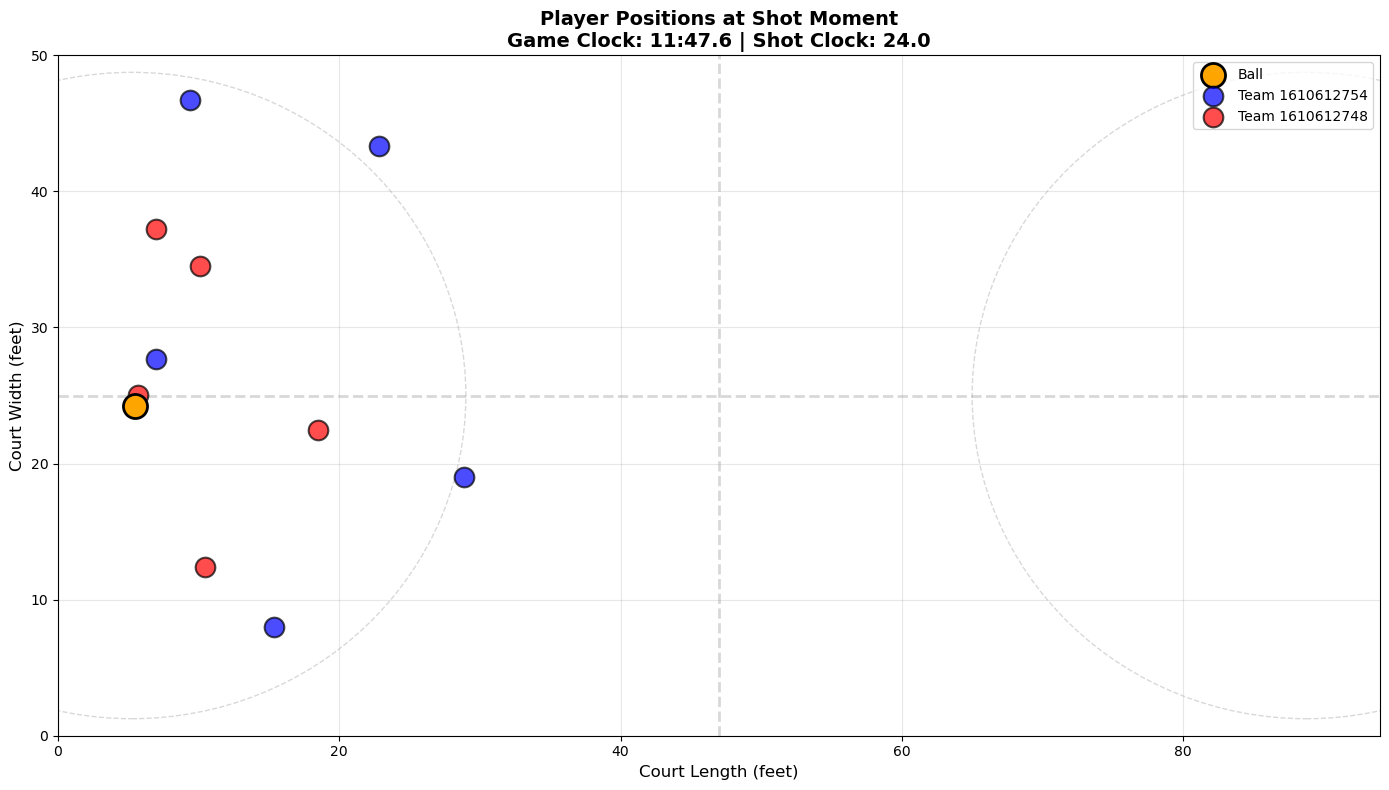


GENERAL TRACKING STATISTICS
Total frames: 4,228
Unique games: 1
Total shots: 9
Made shots: 2,151 frames
Missed shots: 2,077 frames


In [35]:
def analyze_specific_shot(shot_tracking_data, shot_index=0):
    """
    Analyze and display information about a specific shot
    """
    if shot_index >= len(shot_tracking_data):
        print("Invalid shot index")
        return None
    
    shot = shot_tracking_data[shot_index]
    info = shot['info']
    tracking = shot['tracking']
    
    print(f"\n{'='*60}")
    print(f"SHOT INFORMATION")
    print(f"{'='*60}")
    print(f"Player: {info['player_id']}")
    print(f"Team: {info['team']}")
    print(f"Result: {info['shot_result']}")
    print(f"Description: {info['description']}")
    print(f"Game ID: {info['game_id']}")
    print(f"Available frames: {len(tracking)}")
    print(f"{'='*60}")
    
    return tracking


def visualize_shot_positions(tracking_df, frame_num=0):
    """
    Visualize player and ball positions at a specific frame
    """
    if tracking_df.empty or frame_num >= len(tracking_df):
        print("Frame not available")
        return
    
    frame = tracking_df.iloc[frame_num]

    # Nuova logica di formattazione del tempo
    total_seconds = frame["game_clock"]
    minutes = int(total_seconds // 60)
    seconds = total_seconds % 60
    
    # Formattazione M:SS.S
    game_clock_formatted = f"{minutes}:{seconds:04.1f}"

    plt.figure(figsize=(14, 8))
    
    # Draw court boundaries
    plt.xlim(0, 94)
    plt.ylim(0, 50)
    
    # Draw court lines
    plt.axhline(y=25, color='gray', linestyle='--', alpha=0.3, linewidth=2)
    plt.axvline(x=47, color='gray', linestyle='--', alpha=0.3, linewidth=2)
    
    # Draw three-point line (simplified)
    circle1 = plt.Circle((5.25, 25), 23.75, color='gray', fill=False, linestyle='--', alpha=0.3)
    circle2 = plt.Circle((94-5.25, 25), 23.75, color='gray', fill=False, linestyle='--', alpha=0.3)
    plt.gca().add_patch(circle1)
    plt.gca().add_patch(circle2)

    # Ball position
    if 'ball_x' in frame and 'ball_y' in frame:
        plt.scatter(frame['ball_x'], frame['ball_y'], 
                    c='orange', s=300, marker='o', 
                    edgecolors='black', linewidths=2,
                    label='Ball', zorder=3)
    
    # Player positions
    player_cols = [col for col in tracking_df.columns if '_x' in col and 'player_' in col]
    
    teams_plotted = set()
    
    for col in player_cols:
        player_idx = col.split('_')[1]
        x_col = f'player_{player_idx}_x'
        y_col = f'player_{player_idx}_y'
        team_col = f'player_{player_idx}_team_id'

        if x_col in frame and y_col in frame and not pd.isna(frame[x_col]):
            team_id = frame.get(team_col, 0)
            
            # Trova i due team_id unici per assegnare colori diversi
            all_team_ids = [frame.get(f'player_{i}_team_id', 0) for i in range(10)]
            unique_teams = list(set([t for t in all_team_ids if not pd.isna(t)]))
            
            if len(unique_teams) >= 2:
                color = 'blue' if team_id == unique_teams[0] else 'red'
            else:
                color = 'blue'
            
            label = None
            if team_id not in teams_plotted:
                label = f'Team {team_id}'
                teams_plotted.add(team_id)
            
            plt.scatter(frame[x_col], frame[y_col],
                       c=color, s=200, alpha=0.7,
                       edgecolors='black', linewidths=1.5,
                       label=label, zorder=2)

    
    plt.title(f'Player Positions at Shot Moment\nGame Clock: {game_clock_formatted} | Shot Clock: {frame.get("shot_clock", "N/A")}', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Court Length (feet)', fontsize=12)
    plt.ylabel('Court Width (feet)', fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()         

def tracking_statistics(df_complete):
    """
    Calculate general tracking statistics
    """
    if df_complete.empty:
        print("No data available for statistics")
        return
    
    print(f"\n{'='*60}")
    print(f"GENERAL TRACKING STATISTICS")
    print(f"{'='*60}")
    print(f"Total frames: {len(df_complete):,}")
    print(f"Unique games: {df_complete['game_id'].nunique()}")

    # Count unique shots
    if 'event_num' in df_complete.columns:
        unique_shots = df_complete.groupby(['game_id', 'event_num']).ngroups
        print(f"Total shots: {unique_shots}")
    
    # Shot results
    if 'shot_result' in df_complete.columns:
        made_shots = (df_complete['shot_result'] == 'made').sum()
        missed_shots = (df_complete['shot_result'] == 'missed').sum()
        print(f"Made shots: {made_shots:,} frames")
        print(f"Missed shots: {missed_shots:,} frames")
    
    print(f"{'='*60}")

# Execute analysis examples
if shot_tracking_data and len(shot_tracking_data) > 0:
    # Analyze first shot
    tracking_first_shot = analyze_specific_shot(shot_tracking_data, 0)
    
    # Visualize positions
    if tracking_first_shot is not None and len(tracking_first_shot) > 0:
        visualize_shot_positions(tracking_first_shot, frame_num=0)
    
    # General statistics
    if not df_complete.empty:
        tracking_statistics(df_complete)
else:
    print("\nNo shot data available for analysis")

## Advanced Shot Analysis

In [36]:
def extract_shot_moment_frames(tracking_df, window_seconds=2):
    """
    Extract frames during the critical moment of the shot
    (last N seconds before release)
    """
    tracking_df = tracking_df.sort_values('game_clock', ascending=False).copy()
    
    # Take the last frames (shot moment) - assuming 25 fps
    shot_frames = tracking_df.head(int(25 * window_seconds))
    
    return shot_frames

def calculate_player_velocities(tracking_df):
    """
    Calculate velocity for each player frame by frame
    """
    tracking_df = tracking_df.sort_values('game_clock', ascending=False).copy()
    
    player_cols = [col for col in tracking_df.columns if '_x' in col and 'player_' in col]
    
    for col in player_cols:
        player_idx = col.split('_')[1]
        x_col = f'player_{player_idx}_x'
        y_col = f'player_{player_idx}_y'

        if x_col in tracking_df.columns and y_col in tracking_df.columns:
            # Calculate distance between consecutive frames
            dx = tracking_df[x_col].diff()
            dy = tracking_df[y_col].diff()
            velocity = np.sqrt(dx**2 + dy**2) * 25  # 25 fps = velocity in feet/second
            
            tracking_df[f'player_{player_idx}_velocity'] = velocity
    
    return tracking_df

def find_shooter_and_defenders(tracking_df, shot_info):
    """
    Identify the shooter and closest defenders
    """
    if tracking_df.empty:
        return []
    
    # Frame at shot moment (first frame)
    shot_frame = tracking_df.iloc[0]
    
    player_cols = [col for col in tracking_df.columns if '_x' in col and 'player_' in col]
    
    distances = {}
    
    ball_x = shot_frame.get('ball_x', 0)
    ball_y = shot_frame.get('ball_y', 0)
    for col in player_cols:
        player_idx = col.split('_')[1]
        x_col = f'player_{player_idx}_x'
        y_col = f'player_{player_idx}_y'
        team_col = f'player_{player_idx}_team_id'
        id_col = f'player_{player_idx}_player_id'
        
        if x_col in shot_frame and y_col in shot_frame:
            if pd.isna(shot_frame[x_col]) or pd.isna(shot_frame[y_col]):
                continue
                
            dist = np.sqrt((shot_frame[x_col] - ball_x)**2 + 
                          (shot_frame[y_col] - ball_y)**2)
            
            distances[player_idx] = {
                'distance': dist,
                'x': shot_frame[x_col],
                'y': shot_frame[y_col],
                'team_id': shot_frame.get(team_col, 'Unknown'),
                'player_id': shot_frame.get(id_col, 'Unknown')
            }
    
    # Sort by distance
    sorted_distances = sorted(distances.items(), key=lambda x: x[1]['distance'])
    
    return sorted_distances

def shot_difficulty_analysis(tracking_df):
    """
    Analyze shot difficulty based on defender proximity
    """
    if tracking_df.empty:
        return None
    
    shot_frame = tracking_df.iloc[0]
    
    ball_x = shot_frame.get('ball_x', 0)
    ball_y = shot_frame.get('ball_y', 0)
    
    player_cols = [col for col in tracking_df.columns if '_x' in col and 'player_' in col]
    
    defender_distances = []
    
    for col in player_cols:
        player_idx = col.split('_')[1]
        x_col = f'player_{player_idx}_x'
        y_col = f'player_{player_idx}_y'

        if x_col in shot_frame and y_col in shot_frame:
            if pd.isna(shot_frame[x_col]):
                continue
                
            dist = np.sqrt((shot_frame[x_col] - ball_x)**2 + 
                          (shot_frame[y_col] - ball_y)**2)
            defender_distances.append(dist)
    
    defender_distances.sort()
    
    # Closest defender (excluding shooter who should be at distance 0)
    closest_defender = defender_distances[1] if len(defender_distances) > 1 else None
    
    return {
        'closest_defender_distance': closest_defender,
        'num_defenders_within_5ft': sum(1 for d in defender_distances[1:] if d < 5),
        'num_defenders_within_10ft': sum(1 for d in defender_distances[1:] if d < 10),
    }


# Example usage of advanced functions
if shot_tracking_data and len(shot_tracking_data) > 0:
    print("\n" + "="*60)
    print("ADVANCED ANALYSIS OF FIRST SHOT")
    print("="*60)
    
    first_shot = shot_tracking_data[0]
    tracking = first_shot['tracking']
    
    # Calculate velocities
    tracking_with_velocity = calculate_player_velocities(tracking)
    
    # Find shooter and defenders
    distances = find_shooter_and_defenders(tracking, first_shot['info'])
    
    print("\nPlayers ordered by distance from ball:")
    for idx, (player_idx, info) in enumerate(distances[:5]):
        print(f"{idx+1}. Player {player_idx} (ID: {info['player_id']}): {info['distance']:.2f} feet from ball")
     
    # Shot difficulty analysis
    difficulty = shot_difficulty_analysis(tracking)
    if difficulty:
        print("\nShot Difficulty Metrics:")
        print(f"Closest defender: {difficulty['closest_defender_distance']:.2f} feet")
        print(f"Defenders within 5 feet: {difficulty['num_defenders_within_5ft']}")
        print(f"Defenders within 10 feet: {difficulty['num_defenders_within_10ft']}")

print("\n" + "="*60)
print("CODE EXECUTION COMPLETED!")
print("="*60)   


ADVANCED ANALYSIS OF FIRST SHOT

Players ordered by distance from ball:
1. Player 9 (ID: 202355): 0.81 feet from ball
2. Player 1 (ID: 101133): 3.71 feet from ball
3. Player 8 (ID: 201609): 11.23 feet from ball
4. Player 5 (ID: 2548): 12.85 feet from ball
5. Player 7 (ID: 2736): 13.05 feet from ball

Shot Difficulty Metrics:
Closest defender: 3.71 feet
Defenders within 5 feet: 1
Defenders within 10 feet: 1

CODE EXECUTION COMPLETED!
